# MarkdownDeck: Diagnostic Data Transformation & Testing Notebook

**Version: 0.1.0 (Reflects state after recent API error fixes)**


## 🎯 Purpose of This Notebook

This Jupyter Notebook is designed as a **diagnostic and testing tool** for the `markdowndeck` Python package. Its primary functions are:
1.  **Arbitrary Input Testing:** To allow developers and LLMs to input any Markdown string and trace its transformation through the entire MarkdownDeck pipeline.
2.  **Intermediate State Inspection:** To provide detailed views (JSON dumps and visualizations) of the data structures at each critical stage of processing (parsing, layout, API request generation).
3.  **Layout Debugging:** To visually inspect the calculated layout of slides and elements using the `markdowndeck.visualization` submodule, helping to diagnose issues like element overlap and incorrect placement.
4.  **API Request Validation:** To examine the exact Google Slides API requests generated for a given Markdown input before they are sent, aiding in debugging API-level errors.
5.  **Regression Testing Support:** To serve as a repeatable environment for testing changes to the MarkdownDeck library against known complex inputs.

**This notebook is crucial for debugging layout/styling issues and understanding how specific Markdown inputs are processed.**

## ⚙️ How to Run This Notebook
1.  **Monorepo Context:** This notebook assumes it's being run from within the `arclio-mcp-tooling` monorepo structure.
2.  **Virtual Environment:** Ensure your Python virtual environment is activated:
    ```bash
    # From arclio-mcp-tooling root:
    source .venv/bin/activate
    ```
3.  **Editable Install:** `markdowndeck` should be installed in editable mode:
    ```bash
    # From arclio-mcp-tooling root:
    make install-editable PKGS="markdowndeck"
    ```
4.  **Jupyter Server:** Start Jupyter from the monorepo root:
    ```bash
    jupyter notebook
    ```
    Then, open this notebook file.
5.  **Kernel:** Use the Python kernel associated with your virtual environment.
6.  **Run Cells:** Execute cells sequentially. You can modify the Markdown input in Cell 2 to test different scenarios.


## 🛠️ Initial Setup & Imports
Import necessary libraries, configure logging, and define helper functions.


In [1]:
import os
import sys
import json
import logging
from copy import deepcopy
import textwrap # For visualization text wrapping

# --- Path Setup ---
# Assuming the notebook is in a 'notebooks' subdirectory of the project root
# Or directly in the project root if arclio-mcp-tooling is the project root.
try:
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
except NameError:
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

packages_dir = os.path.join(project_root, "packages")
markdowndeck_path = os.path.join(packages_dir, "markdowndeck", "src")

if packages_dir not in sys.path:
    sys.path.insert(0, packages_dir)
if markdowndeck_path not in sys.path:
    sys.path.insert(0, markdowndeck_path)

print(f"Adjusted sys.path. Relevant paths for import:")
print(f"  Project Root (assumed): {project_root}")
print(f"  Packages Directory: {packages_dir}")
print(f"  MarkdownDeck Src: {markdowndeck_path}")

# Configure basic logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s")
# For more detailed debug output:
logging.getLogger("markdowndeck.parser").setLevel(logging.DEBUG)
logging.getLogger("markdowndeck.parser.section.section_parser").setLevel(logging.DEBUG) # Often useful
logging.getLogger("markdowndeck.parser.content.content_parser").setLevel(logging.DEBUG)
logging.getLogger("markdowndeck.layout").setLevel(logging.DEBUG)
logging.getLogger("markdowndeck.layout.calculator.section_layout").setLevel(logging.DEBUG) # Very verbose
logging.getLogger("markdowndeck.api").setLevel(logging.DEBUG)


# Core MarkdownDeck components
from markdowndeck.parser import Parser as MdDeckParser
from markdowndeck.parser.slide_extractor import SlideExtractor
# Other specific parsers can be imported if needed for granular checks, but MdDeckParser is the main entry.

from markdowndeck.models import (
    Deck, Slide, Section, Element, TextElement, ListElement, ListItem,
    CodeElement, ImageElement, TableElement, TextFormat,
    ElementType, SlideLayout, AlignmentType, VerticalAlignmentType, TextFormatType
)

from markdowndeck.layout import LayoutManager
from markdowndeck.api import ApiRequestGenerator
from markdowndeck.visualization import SlideVisualizer # For the enhanced visualizer

# For pretty printing outputs
def enhanced_json_default_for_diag(o):
    if isinstance(o, (ElementType, SlideLayout, AlignmentType, VerticalAlignmentType, TextFormatType)):
        return o.value
    if hasattr(o, "__dict__"):
        return o.__dict__
    if isinstance(o, tuple): # Convert tuples (like position, size) to lists for JSON
        return list(o)
    try:
        return str(o) # Fallback for other types
    except Exception:
        return f"<Unserializable object: {type(o).__name__}>"

def pprint_obj_diag(obj, default_handler=enhanced_json_default_for_diag, indent=2):
    try:
        print(json.dumps(obj, default=default_handler, indent=indent))
    except TypeError as e:
        print(f"Error during JSON serialization: {e}. Object: {obj}")


print("\n✅ Diagnostic Setup Complete. Core components imported.")


Adjusted sys.path. Relevant paths for import:
  Project Root (assumed): /Users/e729/Workspace/Rizz-Buzz/arclio-mcp-tooling
  Packages Directory: /Users/e729/Workspace/Rizz-Buzz/arclio-mcp-tooling/packages
  MarkdownDeck Src: /Users/e729/Workspace/Rizz-Buzz/arclio-mcp-tooling/packages/markdowndeck/src

✅ Diagnostic Setup Complete. Core components imported.


## 📝 Input Markdown for Diagnosis

Paste or define the Markdown content you want to diagnose in the cell below.
By default, it uses the `example_real_world_markdown` which previously exhibited layout issues.


In [2]:
# This is the Markdown that was causing layout issues (e.g., on slide 6 / "Beyond the Board")
# and was also used in Cell 23 of the original exploration notebook.
diagnostic_markdown_input = """
[background=url(https://images.unsplash.com/photo-1586165368502-1bad197a6461?ixlib=rb-1.2.1&auto=format&fit=crop&w=1920&h=1080&q=80)][color=white]\n# The Art of Chess: Beyond the Board\n[align=center][fontsize=36]\n\nChess is not merely a game, but a canvas for strategic brilliance\n\n[align=center][fontsize=22]\n*Exploring the Beautiful Complexity of the Royal Game*\n\n<!-- notes: Begin with energy and passion. Establish that this presentation goes beyond basic chess rules - we\'re exploring the artistic and intellectual depths that make chess timeless. Pause briefly after the title to let the audience take in the beautiful backdrop. -->\n\n===\n\n[background=#1a1a1a][color=white]\n# The Invisible Architecture\n\n[width=45%][align=left][padding=20]\n## Chess Thinking is Pattern Recognition\n[fontsize=20]\n- Grandmasters see the board differently\n- Mental "chunks" of piece configurations\n- Recognition of tactical motifs\n- Positional understanding through patterns\n\n***\n\n[width=55%][align=right][background=url(https://images.unsplash.com/photo-1528819622765-d6bcf132f793?ixlib=rb-1.2.1&auto=format&fit=crop&w=1000&q=80)][background-opacity=0.8][padding=20]\n\n![Pattern Recognition in Chess](https://images.pexels.com/photos/5499902/pexels-photo-5499902.jpeg?auto=compress&cs=tinysrgb&w=600)\n\n<!-- notes: Explain how grandmasters don\'t calculate every possible move but recognize patterns intuitively. The human brain processes chess positions as meaningful chunks rather than individual pieces. This pattern recognition is similar to how we recognize faces or language. Compare to how an artist sees color relationships or a musician hears harmonies. -->\n\n===\n\n[background=#2d1a47][color=white]\n# The Tactical Symphony\n[align=center][padding=10]\n\n[width=100%][align=center]\n![Chess Tactics](https://images.pexels.com/photos/260024/pexels-photo-260024.jpeg?auto=compress&cs=tinysrgb&w=1200)\n\n---\n\n[width=30%][align=center][border=2pt solid #9966CC][padding=10][background=#3d2a57]\n## Forks\n[align=center]\n![Knight Fork](https://www.chess.com/bundles/web/images/image-default.svg)\n\n***\n\n[width=30%][align=center][border=2pt solid #9966CC][padding=10][background=#3d2a57]\n## Pins\n[align=center]\n![Bishop Pin](https://www.chess.com/bundles/web/images/image-default.svg)\n\n***\n\n[width=30%][align=center][border=2pt solid #9966CC][padding=10][background=#3d2a57]\n## Skewers\n[align=center]\n![Queen Skewer](https://www.chess.com/bundles/web/images/image-default.svg)\n\n<!-- notes: Describe these tactical patterns as musical notes in a symphony. Each has its own character but combines to create beautiful combinations. Highlight how these simple tactical motifs intertwine to create complex combinations that can be breathtaking in their execution. Reference a famous tactical game like Kasparov vs. Topalov 1999 where multiple tactical themes converged. -->\n\n===\n\n[background=#0a2e5c][color=white]\n# Strategic Imbalances: The Heart of Decision-Making\n[align=center]\n\n[width=100%][align=center][padding=20]\n[cell-align=center][border=1pt solid #4d88ff][background=#0e3978]\n| Imbalance | White Advantage | Black Advantage |\n|-----------|-----------------|-----------------|\n| Material | Extra pawn | Extra exchange |\n| Pawn Structure | Better pawn majority | No weaknesses |\n| Space | Control of center | Counterattack potential |\n| Development | Faster mobilization | Solid position |\n| Initiative | Attacking chances | Defensive resources |\n\n<!-- notes: Explain how chess mastery is about understanding and creating imbalances. Quote Grandmaster Larry Kaufman: "Chess is the management of imbalances." Emphasize that there is no perfect position - only trade-offs. The art of chess is navigating these imbalances to create positions where your advantages outweigh your disadvantages. This is where the true decision-making depth exists. -->\n\n===\n\n[background=url(https://images.unsplash.com/photo-1580541832626-2a7131ee809f?ixlib=rb-1.2.1&auto=format&fit=crop&w=1920&h=1080&q=80)][background-opacity=0.7][color=white]\n# The Psychology of Chess\n[align=center][padding=10]\n\n[width=48%][align=left][background=#1a1a1a][background-opacity=0.8][padding=20][border=2pt solid #ff3366]\n## The Inner Game\n[fontsize=20]\n- Managing time pressure\n- Dealing with mistakes\n- Emotional resilience\n- Preparation vs. intuition\n- Recognizing psychological patterns\n\n***\n\n[width=48%][align=right][background=#1a1a1a][background-opacity=0.8][padding=20][border=2pt solid #33cc99]\n## Famous Psychological Battles\n[fontsize=20]\n- Fischer vs. Spassky (1972)\n- Kasparov vs. Karpov (1984-1985)\n- Kasparov vs. Deep Blue (1997)\n- Carlsen\'s pressure technique\n\n<!-- notes: The psychological dimension of chess is perhaps its most human element. Discuss how champions like Magnus Carlsen deliberately choose "boring" positions to mentally exhaust opponents. Mention the concept of "Zugzwang" - being forced to make a move that worsens your position - as both a tactical pattern and psychological torture. This connection between mind and board is what makes chess a profound human experience. -->\n\n===\n\n[background=#330033][color=white]\n# The Algorithmic Lens\n[align=center]\n\n[width=50%][fontsize=18][padding=20]\nChess engines reveal mathematical beauty in the game:\n\n```python\ndef minimax(position, depth, alpha, beta, maximizing_player):\n    if depth == 0 or game_over(position):\n        return evaluate_position(position)\n        \n    if maximizing_player:\n        max_eval = float(\'-inf\')\n        for move in get_possible_moves(position):\n            evaluation = minimax(make_move(position, move), \n                                depth - 1, alpha, beta, False)\n            max_eval = max(max_eval, evaluation)\n            alpha = max(alpha, evaluation)\n            if beta <= alpha:\n                break\n        return max_eval\n    else:\n        # Similar code for minimizing player\n```\n\n***\n\n[width=50%][align=center][padding=20]\n![Chess Engine Visualization](https://images.pexels.com/photos/1181263/pexels-photo-1181263.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)\n\n<!-- notes: Explain how chess engines use algorithms like minimax with alpha-beta pruning to evaluate positions. Highlight that even with their immense calculating power, the best engines still evaluate positions based on principles similar to human understanding - material, piece activity, king safety, etc. The difference is quantification and depth. This algorithmic lens gives us insight into the mathematical beauty underlying chess. -->\n\n===\n\n[background=#1a472a][color=white]\n# Opening Principles: The Chess Narrative\n[align=center]\n\n[width=100%][align=center][padding=20]\n[background=#2a5738][border=2pt solid #66cc66][padding=15]\n## Three Phases of the Chess Story\n\n[width=30%][align=center][padding=10]\n### Opening\n- Development\n- Center control\n- King safety\n- Preparation for middlegame\n\n***\n\n[width=30%][align=center][padding=10]\n### Middlegame\n- Tactical opportunities\n- Strategic planning\n- Pawn structure optimization\n- Piece coordination\n\n***\n\n[width=30%][align=center][padding=10]\n### Endgame\n- Pawn promotion\n- King activation\n- Technical precision\n- Mathematical certainty\n\n<!-- notes: Frame chess as a three-act narrative structure. The opening is like the introduction of characters and setting, the middlegame is the development of conflict, and the endgame is the resolution. Each phase has its own principles but connects to create a coherent story. The beauty of chess is that each game tells a unique story despite following the same rules - just like how novels follow narrative structures but tell different tales. -->\n\n===\n\n[background=url(https://images.unsplash.com/photo-1543092587-d8b8feaf362b?ixlib=rb-1.2.1&auto=format&fit=crop&w=1920&h=1080&q=80)][background-opacity=0.7][color=white]\n# Endgame Brilliance: Chess at its Purest\n[align=center]\n\n[width=50%][align=left][background=#000000][background-opacity=0.8][padding=20]\n## The Elegance of Simplicity\n[fontsize=20]\n- King and pawn endgames\n- The concept of opposition\n- Zugzwang and tempo\n- Triangulation technique\n- The rule of the square\n\n***\n\n[width=50%][align=right][background=#000000][background-opacity=0.8][padding=20]\n## Endgame Studies as Art\n[fontsize=20][align=center]\n\n"Chess is like life. Chess is life in miniature."\n\u2014 Garry Kasparov\n\n![Endgame Position](https://images.pexels.com/photos/276033/pexels-photo-276033.jpeg?auto=compress&cs=tinysrgb&w=1200)\n\n<!-- notes: Explain that endgames reveal the mathematical precision of chess. With fewer pieces, the beauty of pure calculation emerges. Describe the famous Lasker-Reichhelm position where white forces a win through zugzwang despite material equality. Endgame studies are like chess puzzles that reveal stunning geometric patterns and unexpected solutions. This is chess at its most elegant - where every move matters and precision is everything. -->\n\n===\n\n[background=#4e1c33][color=white]\n# Chess Composition: Pure Artistic Expression\n[align=center][padding=10]\n\n[width=45%][align=left][padding=20]\n## Chess Problems\n[fontsize=20]\n- Mate in 2/3/more moves\n- Retrograde analysis\n- Helpmates and selfmates\n- Aesthetic criteria:\n  - Economy\n  - Surprise\n  - Uniqueness\n  - Difficulty\n\n***\n\n[width=55%][align=right][padding=20]\n![Chess Problem](https://images.pexels.com/photos/5499923/pexels-photo-5499923.jpeg?auto=compress&cs=tinysrgb&w=1200)\n\n**Example: White to move and mate in 2**\n\n<!-- notes: Chess composition is where chess becomes pure art. Unlike practical chess, compositions prioritize beauty over winning. Explain how composers create positions that would never arise in games but demonstrate beautiful mathematical patterns. Reference the criteria judges use in composition contests: economy (using minimal material), surprise (unexpected first moves), theme (unified ideas), and difficulty. This is chess elevated to art for art\'s sake. -->\n\n===\n\n[background=#663300][color=white]\n# Learning from the Masters\n[align=center][padding=10]\n\n[width=100%][align=center][padding=15]\n[background=#7a4012][border=2pt solid #cc9966][padding=15]\n\n[width=60%][align=left][padding=5]\n## Timeless Wisdom from Chess Giants\n[fontsize=20]\n- Capablanca: "To improve, study endgames"\n- Fischer: "Tactics flow from a superior position"\n- Nimzowitsch: "The threat is stronger than the execution"\n- Lasker: "When you see a good move, look for a better one"\n- Tal: "You must take your opponent into a deep dark forest where 2+2=5"\n\n***\n\n[width=40%][align=right][padding=5]\n![Chess Masters](https://images.pexels.com/photos/260024/pexels-photo-260024.jpeg?auto=compress&cs=tinysrgb&w=600)\n\n<!-- notes: These quotes encapsulate different approaches to chess mastery. Capablanca emphasized fundamentals, Fischer focused on positional preparation for tactics, Nimzowitsch discovered prophylaxis and threats, Lasker was pragmatic and psychological, and Tal was creative and sacrificial. Each master reveals a different facet of chess beauty. The diversity of valid approaches shows how chess accommodates different types of intelligence and creativity. -->\n\n===\n\n[background=#000000][color=white]\n# The Universal Appeal: Chess Across Cultures\n[align=center]\n\n[width=100%][align=center][padding=20]\n![Chess Around the World](https://images.pexels.com/photos/5499924/pexels-photo-5499924.jpeg?auto=compress&cs=tinysrgb&w=1200)\n\n---\n\n[width=30%][align=center][background=#333333][border=2pt solid #3399ff][padding=10]\n## Educational Benefits\n- Critical thinking\n- Planning abilities\n- Pattern recognition\n- Concentration\n- Decision-making\n\n***\n\n[width=30%][align=center][background=#333333][border=2pt solid #ff6633][padding=10]\n## Psychological Benefits\n- Patience development\n- Emotional control\n- Self-confidence\n- Sportsmanship\n- Growth mindset\n\n***\n\n[width=30%][align=center][background=#333333][border=2pt solid #33cc33][padding=10]\n## Social Benefits\n- Cross-generational activity\n- Cultural bridge\n- Online communities\n- Tournament camaraderie\n- Inclusive accessibility\n\n<!-- notes: Chess transcends cultural, linguistic, and age barriers. Discuss how a Russian grandmaster can play a meaningful game with a Chinese schoolchild without sharing a word of language. Mention the educational benefits that have led to chess in schools worldwide. Touch on how chess provides cognitive benefits throughout life, potentially helping with cognitive decline in aging. The universal language of chess connects humans through pure thought. -->\n\n===\n\n[background=url(https://images.unsplash.com/photo-1582143633151-5a5905eeae0b?ixlib=rb-1.2.1&auto=format&fit=crop&w=1920&h=1080&q=80)][background-opacity=0.7][color=white]\n# What Makes Chess Beautiful?\n[align=center][fontsize=36][padding=20]\n\n[width=100%][align=center][background=#000000][background-opacity=0.7][padding=20][border=2pt solid #9933cc]\n\nChess combines the:\n[fontsize=24]\n- **Tactical precision** of mathematics\n- **Strategic depth** of philosophy  \n- **Psychological intensity** of sports\n- **Creative expression** of art\n- **Logical rigor** of science\n- **Narrative structure** of literature\n- **Universal language** of humanity\n\n<!-- notes: Conclude by synthesizing all previous slides. Chess is beautiful because it operates simultaneously on multiple levels: mathematical precision, strategic depth, psychological warfare, creative expression, logical rigor, narrative structure, and universal accessibility. It\'s a microcosm of human thought and a mirror of the mind. Final thought: "Perhaps chess endures because it offers us a rare glimpse of pure human potential - what we can accomplish with nothing but concentrated thought and imagination." -->\n
"""


print("✅ Diagnostic Markdown Input loaded.")
print("-" * 30)

# Print only a preview if it's very long

preview_lines = 20
print("\n".join(diagnostic_markdown_input.splitlines()[:preview_lines])) if len(diagnostic_markdown_input.splitlines()) > preview_lines else None
print("...")
print("-" * 30)

✅ Diagnostic Markdown Input loaded.
------------------------------

[background=url(https://images.unsplash.com/photo-1586165368502-1bad197a6461?ixlib=rb-1.2.1&auto=format&fit=crop&w=1920&h=1080&q=80)][color=white]
# The Art of Chess: Beyond the Board
[align=center][fontsize=36]

Chess is not merely a game, but a canvas for strategic brilliance

[align=center][fontsize=22]
*Exploring the Beautiful Complexity of the Royal Game*

<!-- notes: Begin with energy and passion. Establish that this presentation goes beyond basic chess rules - we're exploring the artistic and intellectual depths that make chess timeless. Pause briefly after the title to let the audience take in the beautiful backdrop. -->

===

[background=#1a1a1a][color=white]
# The Invisible Architecture

[width=45%][align=left][padding=20]
## Chess Thinking is Pattern Recognition
[fontsize=20]
...
------------------------------


## ▶️ Pipeline Step 1: Slide Extraction

The `SlideExtractor` splits the raw Markdown into a list of dictionaries, each representing a slide with its top-level attributes (title, content, footer, notes, background).


In [3]:
slide_extractor_diag = SlideExtractor()
raw_slides_data_diag = slide_extractor_diag.extract_slides(diagnostic_markdown_input)

print(f"Number of slides extracted: {len(raw_slides_data_diag)}")
# Optionally print the full raw_slides_data_diag for deep inspection:
# print("\n--- Full Raw Slides Data (Diagnostic) ---")
# pprint_obj_diag(raw_slides_data_diag)

# Print summary of each extracted slide
for i, slide_data in enumerate(raw_slides_data_diag):
    print(f"\n--- Raw Data for Extracted Slide {i+1} ---")
    print(f"  Title: {slide_data.get('title', 'N/A')[:50]}...")
    print(f"  Content Preview: {slide_data.get('content', '')[:100].replace(chr(10), ' ')}...") # Show content on one line for preview
    print(f"  Footer: {slide_data.get('footer')}")
    print(f"  Notes Present: {'Yes' if slide_data.get('notes') else 'No'}")
    print(f"  Background: {slide_data.get('background')}")
    print(f"  Object ID: {slide_data.get('object_id')}")


2025-05-14 14:16:45,607 - markdowndeck.parser.slide_extractor - DEBUG - Extracting slides from markdown
2025-05-14 14:16:45,607 - markdowndeck.parser.slide_extractor - DEBUG - Processing slide 1
2025-05-14 14:16:45,608 - markdowndeck.parser.slide_extractor - DEBUG - Processing slide 2
2025-05-14 14:16:45,608 - markdowndeck.parser.slide_extractor - DEBUG - Processing slide 3
2025-05-14 14:16:45,608 - markdowndeck.parser.slide_extractor - DEBUG - Processing slide 4
2025-05-14 14:16:45,609 - markdowndeck.parser.slide_extractor - DEBUG - Processing slide 5
2025-05-14 14:16:45,609 - markdowndeck.parser.slide_extractor - DEBUG - Processing slide 6
2025-05-14 14:16:45,609 - markdowndeck.parser.slide_extractor - INFO - Extracted 6 slides from markdown


Number of slides extracted: 6

--- Raw Data for Extracted Slide 1 ---
  Title: The Art of Chess: Beyond the Board...
  Content Preview: [color=white]  [align=center][fontsize=36]  Chess is not merely a game, but a canvas for strategic b...
  Footer: None
  Notes Present: Yes
  Background: {'type': 'image', 'value': 'https://images.unsplash.com/photo-1586165368502-1bad197a6461?ixlib=rb-1.2.1&auto=format&fit=crop&w=1920&h=1080&q=80'}
  Object ID: slide_0_beca69

--- Raw Data for Extracted Slide 2 ---
  Title: The Invisible Architecture...
  Content Preview: [color=white]   [width=45%][align=left][padding=20] ## Chess Thinking is Pattern Recognition [fontsi...
  Footer: None
  Notes Present: Yes
  Background: {'type': 'color', 'value': '#1a1a1a'}
  Object ID: slide_1_b7b58a

--- Raw Data for Extracted Slide 3 ---
  Title: The Tactical Symphony...
  Content Preview: [color=white]  [align=center][padding=10]  [width=100%][align=center] ![Chess Tactics](https://image...
  Footer: None
  Note

## ▶️ Pipeline Step 2: Full Parsing (MdDeckParser)

The `MdDeckParser` orchestrates `SectionParser`, `DirectiveParser`, and `ContentParser` to convert the raw slide data into a structured `Deck` object containing `Slide` objects. Each `Slide` will have its `elements` list populated (flat list of all elements) and its `sections` attribute holding the hierarchical section structure (where each `Section` also has its own `elements` list).


In [4]:
main_parser_diag = MdDeckParser()

# Provide a title for the deck
deck_title_diag = "Diagnostic Deck - Real World Example"
parsed_deck_unlaid = main_parser_diag.parse(diagnostic_markdown_input, title=deck_title_diag)


print("\n--- Full Parsed Deck (Unlaid) JSON ---")
pprint_obj_diag(parsed_deck_unlaid)

2025-05-14 14:16:45,613 - markdowndeck.parser - INFO - Starting to parse markdown into presentation deck
2025-05-14 14:16:45,613 - markdowndeck.parser.slide_extractor - DEBUG - Extracting slides from markdown
2025-05-14 14:16:45,613 - markdowndeck.parser.slide_extractor - DEBUG - Processing slide 1
2025-05-14 14:16:45,613 - markdowndeck.parser.slide_extractor - DEBUG - Processing slide 2
2025-05-14 14:16:45,614 - markdowndeck.parser.slide_extractor - DEBUG - Processing slide 3
2025-05-14 14:16:45,614 - markdowndeck.parser.slide_extractor - DEBUG - Processing slide 4
2025-05-14 14:16:45,614 - markdowndeck.parser.slide_extractor - DEBUG - Processing slide 5
2025-05-14 14:16:45,614 - markdowndeck.parser.slide_extractor - DEBUG - Processing slide 6
2025-05-14 14:16:45,615 - markdowndeck.parser.slide_extractor - INFO - Extracted 6 slides from markdown
2025-05-14 14:16:45,615 - markdowndeck.parser - INFO - Extracted 6 slides from markdown
2025-05-14 14:16:45,615 - markdowndeck.parser - DEBUG


--- Full Parsed Deck (Unlaid) JSON ---
{
  "slides": [
    {
      "elements": [
        {
          "element_type": "title",
          "position": [
            100,
            100
          ],
          "size": [
            600,
            100
          ],
          "object_id": null,
          "directives": {},
          "text": "The Art of Chess: Beyond the Board",
          "formatting": [],
          "horizontal_alignment": "center",
          "vertical_alignment": "top"
        }
      ],
      "layout": "TITLE_ONLY",
      "notes": "Begin with energy and passion. Establish that this presentation goes beyond basic chess rules - we're exploring the artistic and intellectual depths that make chess timeless. Pause briefly after the title to let the audience take in the beautiful backdrop.",
      "object_id": "slide_0",
      "footer": null,
      "sections": [
        {
          "content": "Chess is not merely a game, but a canvas for strategic brilliance\n\n[align=center][fo

## ▶️ Pipeline Step 3: Layout Management

The `LayoutManager` processes the `parsed_deck_unlaid` to calculate positions and sizes for all sections and elements. It handles section-based layouts, directives, and potential content overflow.


In [5]:
layout_manager_diag = LayoutManager()
deck_after_layout_diag = deepcopy(parsed_deck_unlaid) # Work on a copy

final_laid_out_slides_diag = []
if deck_after_layout_diag.slides:
    for i, current_slide_to_layout in enumerate(list(deck_after_layout_diag.slides)):
        print(f"\n--- Processing Layout for Parsed Slide {i+1} (Object ID: {current_slide_to_layout.object_id}) ---")

        # Safeguard for element sizes (as in original notebook)
        # This ensures elements have a preliminary size before PositionCalculator refines them.
        # It's important for elements within sections too.
        def ensure_default_sizes(elements_list):
            for el in elements_list:
                if not hasattr(el, "size") or el.size is None:
                    el.size = (layout_manager_diag.max_content_width, 50) # A generic default

        ensure_default_sizes(current_slide_to_layout.elements)
        for sec_top in current_slide_to_layout.sections:
            ensure_default_sizes(sec_top.elements)
            if hasattr(sec_top, 'subsections'):
                for subsec in sec_top.subsections:
                    ensure_default_sizes(subsec.elements)

        slide_or_slides_list_from_layout = layout_manager_diag.calculate_positions(current_slide_to_layout)

        if isinstance(slide_or_slides_list_from_layout, list):
            print(f"  LayoutManager returned {len(slide_or_slides_list_from_layout)} slides (overflow might have occurred).")
            final_laid_out_slides_diag.extend(slide_or_slides_list_from_layout)
        else: # Should be a single Slide instance
            print("  LayoutManager returned a single slide instance.")
            final_laid_out_slides_diag.append(slide_or_slides_list_from_layout)

    deck_after_layout_diag.slides = final_laid_out_slides_diag
else:
    print("No slides in parsed_deck_unlaid to process for layout.")

print(f"\n--- Deck After Layout (Total Slides: {len(deck_after_layout_diag.slides)}) ---")
print("\n--- Full Deck After Layout (JSON) ---")
pprint_obj_diag(deck_after_layout_diag)


2025-05-14 14:16:45,845 - markdowndeck.layout.calculator.base - DEBUG - Fixed body zone: top=140.0, left=50, width=620, height=185.0, bottom=325.0
2025-05-14 14:16:45,846 - markdowndeck.layout.overflow - DEBUG - Fixed body zone for overflow detection: top=140.0, bottom=325.0, height=185.0
2025-05-14 14:16:45,847 - markdowndeck.layout - DEBUG - Calculating positions for slide: slide_0
2025-05-14 14:16:45,848 - markdowndeck.layout.calculator.base - DEBUG - Using section-based layout for slide slide_0
2025-05-14 14:16:45,848 - markdowndeck.layout.calculator.section_layout - DEBUG - Distributing space for 1 sections in area: left=50.0, top=135.0, width=620.0, height=185.0, is_vertical=True
2025-05-14 14:16:45,848 - markdowndeck.layout.calculator.section_layout - DEBUG - Allocated 185.0 points per implicit section
2025-05-14 14:16:45,848 - markdowndeck.layout.calculator.section_layout - DEBUG - Positioned section section-v0-h0-c35103: pos=(50.0, 135.0), size=(620.0, 185.0)
2025-05-14 14:16:


--- Processing Layout for Parsed Slide 1 (Object ID: slide_0) ---
  LayoutManager returned a single slide instance.

--- Processing Layout for Parsed Slide 2 (Object ID: slide_1) ---
  LayoutManager returned a single slide instance.

--- Processing Layout for Parsed Slide 3 (Object ID: slide_2) ---
  LayoutManager returned a single slide instance.

--- Processing Layout for Parsed Slide 4 (Object ID: slide_3) ---
  LayoutManager returned a single slide instance.

--- Processing Layout for Parsed Slide 5 (Object ID: slide_4) ---
  LayoutManager returned a single slide instance.

--- Processing Layout for Parsed Slide 6 (Object ID: slide_5) ---
  LayoutManager returned a single slide instance.

--- Deck After Layout (Total Slides: 6) ---

--- Full Deck After Layout (JSON) ---
{
  "slides": [
    {
      "elements": [
        {
          "element_type": "title",
          "position": [
            81.0,
            70
          ],
          "size": [
            558.0,
            40
   

In [6]:

# Print summary of positions and sizes for elements on a specific slide (e.g., the last one which had issues)
if deck_after_layout_diag.slides:
    slide_to_inspect_idx = -1 # Inspect the last slide
    inspected_slide = deck_after_layout_diag.slides[slide_to_inspect_idx]
    print(f"\n--- Layout Details for Slide {len(deck_after_layout_diag.slides)} (ID: {inspected_slide.object_id}) ---")
    for el_idx, el in enumerate(inspected_slide.elements):
        pos = list(el.position) if hasattr(el, 'position') and el.position else "N/A"
        sz = list(el.size) if hasattr(el, 'size') and el.size else "N/A"
        print(f"  Element {el_idx} ({el.element_type.value}): Pos={pos}, Size={sz}")
        if hasattr(el, 'text') and el.text:
             print(f"    Text: {el.text[:40].replace(chr(10), ' ')}...")
        elif hasattr(el, 'url') and el.url:
             print(f"    URL: {el.url[:40]}...")

    # Also inspect section geometry if needed
    print("\n  --- Section Geometries ---")
    def print_section_geo(sections, indent=0):
        for s in sections:
            prefix = "  " * indent
            s_pos = list(s.position) if s.position else "N/A"
            s_sz = list(s.size) if s.size else "N/A"
            print(f"{prefix}Section ID: {s.id}, Type: {s.type}, Pos: {s_pos}, Size: {s_sz}")
            if s.subsections:
                print_section_geo(s.subsections, indent + 1)
    print_section_geo(inspected_slide.sections)



--- Layout Details for Slide 6 (ID: slide_5) ---
  Element 0 (title): Pos=[81.0, 70], Size=[558.0, 40]
    Text: The Algorithmic Lens...
  Element 1 (code): Pos=[100, 100], Size=[600, 100]
  Element 2 (image): Pos=[100, 100], Size=[600, 100]
    URL: https://images.pexels.com/photos/1181263...
  Element 3 (title): Pos=[100, 100], Size=[600, 100]
    Text: Opening Principles: The Chess Narrative...
  Element 4 (text): Pos=[100, 100], Size=[600, 100]
    Text: Three Phases of the Chess Story...
  Element 5 (text): Pos=[100, 100], Size=[600, 100]
    Text: Opening...
  Element 6 (bullet_list): Pos=[100, 100], Size=[600, 100]
  Element 7 (text): Pos=[100, 100], Size=[600, 100]
    Text: Middlegame...
  Element 8 (bullet_list): Pos=[100, 100], Size=[600, 100]
  Element 9 (text): Pos=[100, 100], Size=[600, 100]
    Text: Endgame...
  Element 10 (bullet_list): Pos=[100, 100], Size=[600, 100]
  Element 11 (title): Pos=[100, 100], Size=[600, 100]
    Text: Endgame Brilliance: Chess at its Pure

## ▶️ Pipeline Step 4: Visualization (Using Enhanced Visualizer)

Here, we'll use the `SlideVisualizer` from the `markdowndeck.visualization` submodule to render the `deck_after_layout_diag`. This step is crucial for visually inspecting the element placements, sizes, and potential overlaps.

**Note:** The enhancements to `SlideVisualizer` (Task 2 in your request) are intended to make this output more faithful to the intended styling, including colors, relative font sizes, and displaying images from URLs. For this notebook generation, we'll call it assuming these enhancements will be implemented in the submodule.



--- Visualizing All 6 Slides (with Enhanced Visualizer) ---


2025-05-14 14:19:31,560 - matplotlib.axes._base - WARNING - Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
2025-05-14 14:19:31,732 - matplotlib.axes._base - WARNING - Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
2025-05-14 14:19:31,823 - matplotlib.axes._base - WARNING - Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


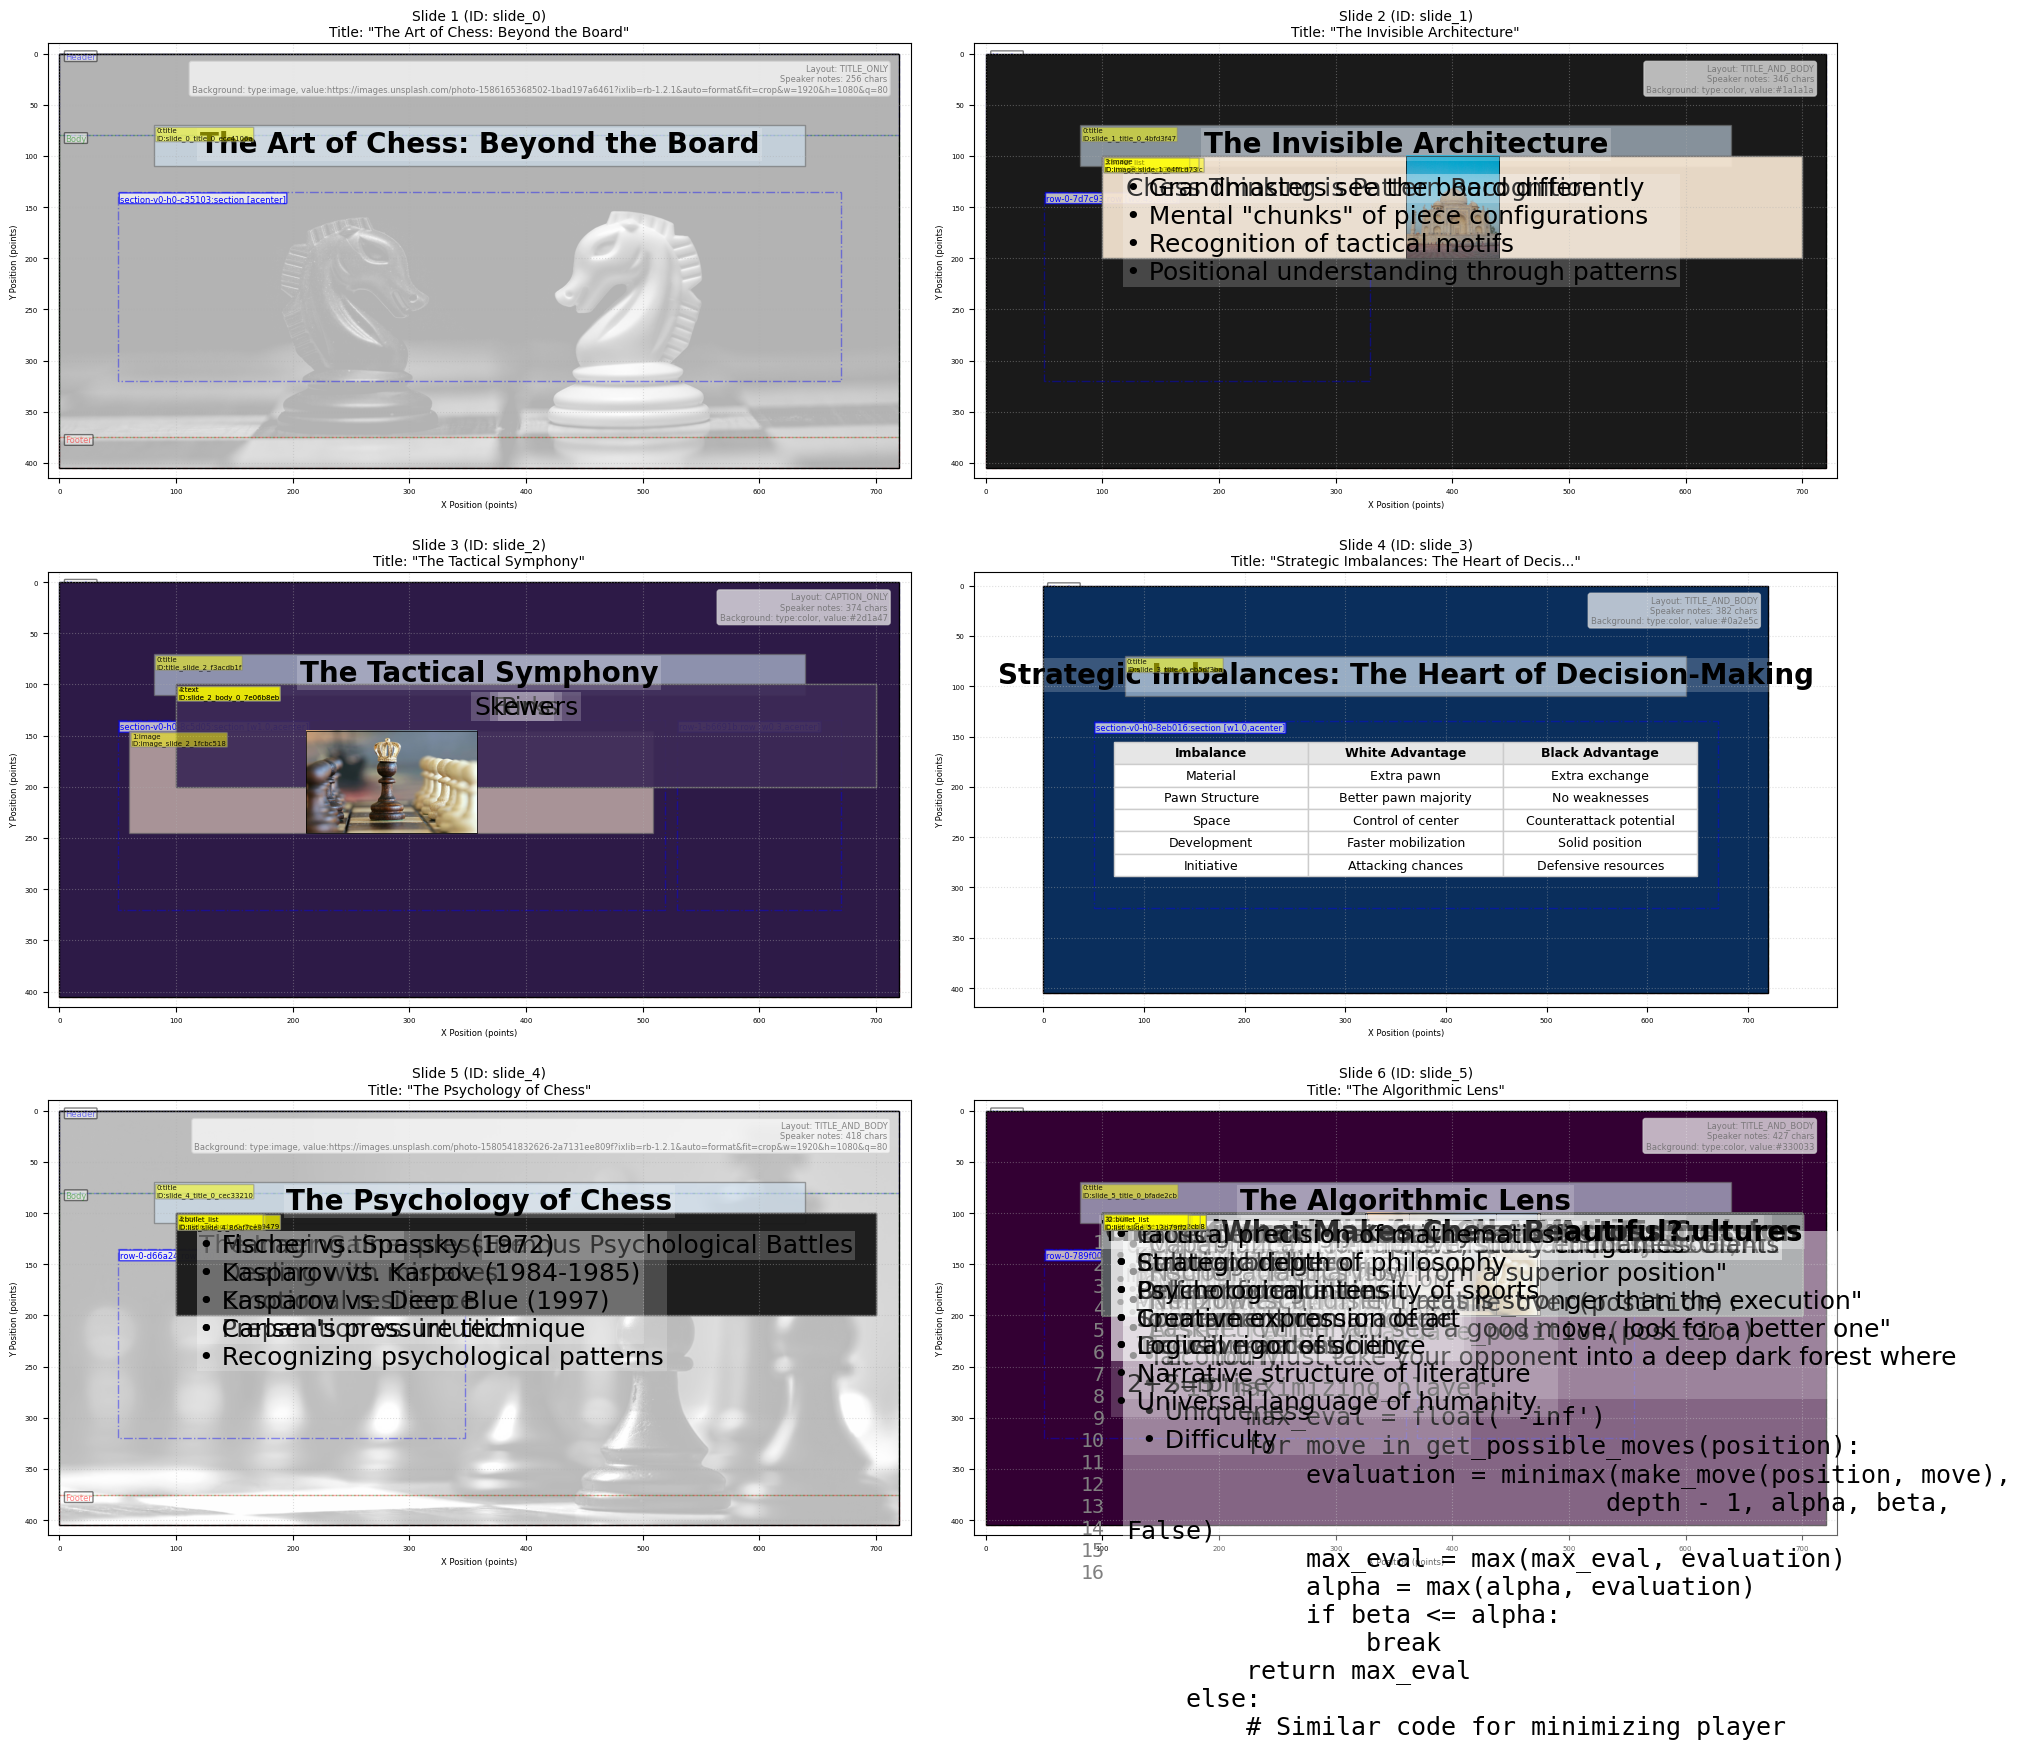

In [11]:
visualizer_diag = SlideVisualizer()

if deck_after_layout_diag.slides:
    print(
        f"\n--- Visualizing All {len(deck_after_layout_diag.slides)} Slides (with Enhanced Visualizer) ---"
    )

    # Use auto-sizing with appropriate layout mode
    visualizer_diag.visualize(
        deck_after_layout_diag,
        scale_factor=1.0,                 # Make slides larger
        vertical_spacing=0.05,            # Minimal vertical spacing (5%)
        horizontal_spacing=0.025,          # Minimal horizontal spacing (5%)
        layout_mode="grid" if len(deck_after_layout_diag.slides) > 3 else "vertical"
    )
else:
    print("No slides with layout data to visualize.")

**Interpreting the Visualization:**

* Carefully examine the output for element overlaps, incorrect sizing, or misplacements, especially on slides known to have issues from the `example_real_world_markdown`.
* The visualization should eventually reflect:
    * Element background colors from `[background=...]` directives.
    * Relative font sizes from `[fontsize=...]`.
    * Text colors from `[color=...]`.
    * Attempted rendering of images from URLs.
    * Clear demarcation of section boundaries.
* This visual output, combined with the JSON dumps of the `Slide` and `Element` models (with their `position` and `size` attributes), provides the data needed to debug layout problems. The warnings from `LayoutManager` (e.g., "Element ... would overflow") in the logs should also correlate with visual issues.


## ▶️ Pipeline Step 5: API Request Generation

Finally, the `ApiRequestGenerator` converts the laid-out `Deck` object into the batches of JSON requests that would be sent to the Google Slides API. Inspecting these requests can be useful for debugging API-level issues if they were still occurring.


In [8]:
api_request_generator_diag = ApiRequestGenerator()
api_batches_diag = []

if deck_after_layout_diag.slides:
    print(f"\n--- Generating API Requests for Diagnostic Deck ({len(deck_after_layout_diag.slides)} slide(s)) ---")
    placeholder_presentation_id_diag = "DIAGNOSTIC_PLACEHOLDER_ID"

    try:
        api_batches_diag = api_request_generator_diag.generate_batch_requests(
            deck_after_layout_diag, placeholder_presentation_id_diag
        )

        print(f"\n--- Summary of Generated API Batches (Diagnostic) ---")
        print(f"Total batches generated: {len(api_batches_diag)}")
        for i, batch in enumerate(api_batches_diag):
            print(f"  Batch {i+1}: For Slide corresponding to original index ~{i}, #Requests: {len(batch.get('requests', []))}")
            # Note: Slide correspondence might shift if overflow occurred.
            # The 'objectId' in the createSlide request is the best link.
            if batch.get("requests") and batch['requests'][0].get('createSlide'):
                 print(f"    Target Slide objectId: {batch['requests'][0]['createSlide'].get('objectId')}")


        # Optionally, print the full JSON for a specific batch (e.g., the one for the problematic slide)
        # slide_with_layout_issues_idx = 5 # Example: If the 6th slide had issues
        # if len(api_batches_diag) > slide_with_layout_issues_idx:
        #     print(f"\n--- Full JSON for Batch {slide_with_layout_issues_idx + 1} (Diagnostic) ---")
        #     pprint_obj_diag(api_batches_diag[slide_with_layout_issues_idx])
        # else:
        #     print(f"\n--- Full JSON for First Batch (Diagnostic) ---") # Fallback to first if index is out of bounds
        #     if api_batches_diag:
        #         pprint_obj_diag(api_batches_diag[0])


    except Exception as e:
        print(f"An error occurred during API request generation for diagnostic deck: {e}")
        logging.exception("API Request Generation Error Details (Diagnostic):")
else:
    print("No slides in deck_after_layout_diag to generate API requests for.")


2025-05-14 14:17:02,190 - markdowndeck.api.api_generator - DEBUG - Initializing API request generator
2025-05-14 14:17:02,191 - markdowndeck.api.request_builders.slide_builder - DEBUG - Created slide request with ID: slide_0, layout: TITLE_ONLY, 1 placeholder mappings. Mapped to model: {<ElementType.TITLE: 'title'>: 'slide_0_title_0_ecc4106a'}
2025-05-14 14:17:02,191 - markdowndeck.api.request_builders.slide_builder - DEBUG - Created background request for slide: slide_0 with fields: pageBackgroundFill.stretchedPictureFill.contentUrl
2025-05-14 14:17:02,191 - markdowndeck.api.request_builders.text_builder - DEBUG - Generated 1 requests for themed element ElementType.TITLE using placeholder slide_0_title_0_ecc4106a
2025-05-14 14:17:02,191 - markdowndeck.api.api_generator - DEBUG - Slide slide_0 has notes but no speaker_notes_object_id yet. Notes will be added in a second pass.
2025-05-14 14:17:02,192 - markdowndeck.api.api_generator - DEBUG - Generated 3 requests for slide slide_0
2025-


--- Generating API Requests for Diagnostic Deck (6 slide(s)) ---


2025-05-14 14:17:03,095 - markdowndeck.api.request_builders.media_builder - DEBUG - Added alt text for image: Pattern Recognition in Chess
2025-05-14 14:17:03,096 - markdowndeck.api.api_generator - DEBUG - Slide slide_1 has notes but no speaker_notes_object_id yet. Notes will be added in a second pass.
2025-05-14 14:17:03,096 - markdowndeck.api.api_generator - DEBUG - Generated 13 requests for slide slide_1
2025-05-14 14:17:03,097 - markdowndeck.api.api_generator - DEBUG - Generated batch for slide 2/6
2025-05-14 14:17:03,098 - markdowndeck.api.request_builders.slide_builder - DEBUG - Created slide request with ID: slide_2, layout: CAPTION_ONLY, 1 placeholder mappings. Mapped to model: {<ElementType.TEXT: 'text'>: 'slide_2_body_0_7e06b8eb', <ElementType.BULLET_LIST: 'bullet_list'>: 'slide_2_body_0_7e06b8eb', <ElementType.ORDERED_LIST: 'ordered_list'>: 'slide_2_body_0_7e06b8eb'}
2025-05-14 14:17:03,099 - markdowndeck.api.request_builders.slide_builder - DEBUG - Created background reques


--- Summary of Generated API Batches (Diagnostic) ---
Total batches generated: 6
  Batch 1: For Slide corresponding to original index ~0, #Requests: 3
    Target Slide objectId: slide_0
  Batch 2: For Slide corresponding to original index ~1, #Requests: 13
    Target Slide objectId: slide_1
  Batch 3: For Slide corresponding to original index ~2, #Requests: 10
    Target Slide objectId: slide_2
  Batch 4: For Slide corresponding to original index ~3, #Requests: 29
    Target Slide objectId: slide_3
  Batch 5: For Slide corresponding to original index ~4, #Requests: 20
    Target Slide objectId: slide_4
  Batch 6: For Slide corresponding to original index ~5, #Requests: 129
    Target Slide objectId: slide_5


## 🧪 Diagnostic Conclusion

This notebook provides a framework for testing arbitrary Markdown inputs with MarkdownDeck. By examining:
1.  The logs generated by the library (especially `DEBUG` level for layout components).
2.  The intermediate `Deck`, `Slide`, `Section`, and `Element` model states (via JSON dumps).
3.  The visual rendering of the slide layouts.
4.  The final generated API requests.